In [11]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from tqdm import tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.multitest
from statsmodels.stats.anova import AnovaRM

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize as Color_Normalize
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.patches import Rectangle

import scipy
from scipy import optimize, stats

import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import pingouin as pg

In [2]:
# To make plots using Matplotlib, you must first enable IPython's matplotlib mode.
# To do this, run the %matplotlib magic command to enable plotting in the current Notebook.
# This magic takes an optional argument that specifies which Matplotlib backend should be used. 
# Most of the time, in the Notebook, you will want to use the inline backend,
# which will embed plots inside the Notebook:
%matplotlib inline

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
dir_root = join('/mnt/ext6/GL/fmri_data')

dir_stat = join(dir_root, 'stats')
dir_GLM_movement = join(dir_stat, 'GLM.Move_Stop')
stat = 'GLM.reward.4s_shifted'
dir_GLM_reward = join(dir_stat, stat)

dir_mask = join(dir_root, 'masks')

In [5]:
list_subj = [
    'GL03', 'GL04', 'GL05', 'GL06', 'GL07'
    , 'GL08', 'GL09', 'GL10', 'GL11', 'GL12'
    , 'GL14', 'GL15', 'GL16', 'GL17', 'GL18'
    , 'GL19', 'GL20', 'GL21', 'GL22', 'GL24'
    , 'GL25', 'GL26', 'GL27', 'GL29'
]

In [6]:
bg_img = join('/usr/local/afni/abin/MNI152_2009_template.nii.gz')

---

In [37]:
zscore_reward = join(dir_GLM_reward, 'GL.reward.group.Zscore.n24.nii')
zscore_motor = join(dir_GLM_movement, 'GL.move-stop.group.Zscore.n24.nii')

In [8]:
threshold = 3.291 # This is a z-score for p=0.001
threshold = 3.8906 # This is a z-score for p=0.0001

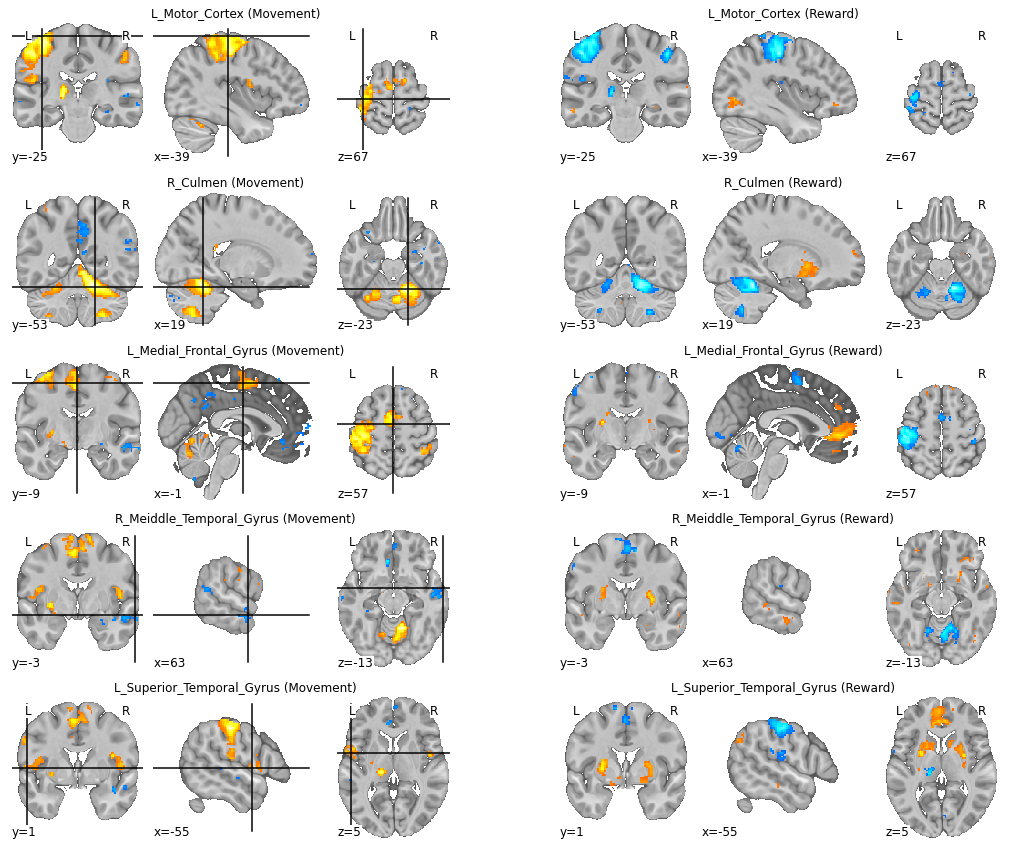

In [42]:
list_coord = {}
list_coord['L_Motor_Cortex'] = (-39,-25,67)
list_coord['R_Culmen'] = (19, -53, -23)
list_coord['L_Medial_Frontal_Gyrus'] = (-1, -9, 57)
list_coord['R_Meiddle_Temporal_Gyrus'] = (63, -3, -13)
list_coord['L_Superior_Temporal_Gyrus'] = (-55, 1, 5)

nrows, ncols = len(list_coord), 2

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols
    , figsize=(9*ncols, 3*nrows)
)
axs = np.concatenate(axs.transpose())
for ii, (region, coord) in enumerate(list_coord.items()):
    ax = axs[ii]
    nilearn.plotting.plot_stat_map(
        stat_map_img=zscore_motor, bg_img=bg_img, black_bg=False
        , threshold=threshold, colorbar=False
        , display_mode='ortho'
        , cut_coords=coord
        , draw_cross=True
        , axes=ax
    )
    ax.set_title('%s (Movement)'%region)
    
    ax = axs[ii+nrows]
    nilearn.plotting.plot_stat_map(
        stat_map_img=zscore_reward, bg_img=bg_img, black_bg=False
        , threshold=threshold, colorbar=False
        , display_mode='ortho'
        , cut_coords=coord
        , draw_cross=False
        , axes=ax
    )
    ax.set_title('%s (Reward)'%region)

---

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
img_NAc = join(dir_mask, 'mask.NAc_2parts.nii')
img_VmPFC = join(dir_mask, 'mask.VmPFC_16parts.nii')

# img_mask = nilearn.image.math_img(
#     img1=img_putamen, img2=img_caudate, img3=img_NAc, img4=img_VmPFC
#     , formula='(img1+img2+img3+img4) > 0'
# )
# nilearn.plotting.plot_roi(img_mask)

/tmp/ipykernel_2851889/2147935094.py:6: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  print(np.unique(img_roi.get_data()))


[0 1]


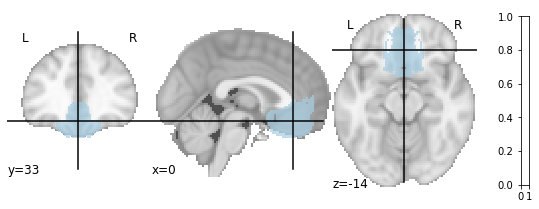

In [22]:
# tmp = nilearn.image.math_img(img1=img_putamen, formula='img1*0')
img_roi = nilearn.image.math_img(
    img1=img_VmPFC
    , formula='img1>0'
)
print(np.unique(img_roi.get_data()))
nilearn.plotting.plot_roi(img_roi, cmap='Paired', colorbar=True)

In [23]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_roi, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['VmPFC']
)

In [25]:
dh = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

,subj,source,ROI,beta


In [26]:
df = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])
dg = pd.DataFrame(columns=['subj', 'source', 'ROI', 'beta'])

for ii, subj in enumerate(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        df = df.append({'subj':subj, 'source':'reward', 'ROI':roi, 'beta':beta}, ignore_index=True)
    ## Move-Stop
    img_beta = join(dir_GLM_movement, '%s.Move-Stop_GLT#0_Coef.tlrc.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for roi, beta in zip(masker.labels, betas):
        dg = dg.append({'subj':subj, 'source':'move-stop', 'ROI':roi, 'beta':beta}, ignore_index=True)

dh = dh.append(df)
dh = dh.append(dg)
dh

,subj,source,ROI,beta
0,GL03,reward,VmPFC,0.166768
1,GL04,reward,VmPFC,0.140682
2,GL05,reward,VmPFC,0.098009
3,GL06,reward,VmPFC,-0.010737
4,GL07,reward,VmPFC,0.057932
5,GL08,reward,VmPFC,0.014855
6,GL09,reward,VmPFC,0.194210
7,GL10,reward,VmPFC,0.073948
8,GL11,reward,VmPFC,0.181756
9,GL12,reward,VmPFC,-0.032951


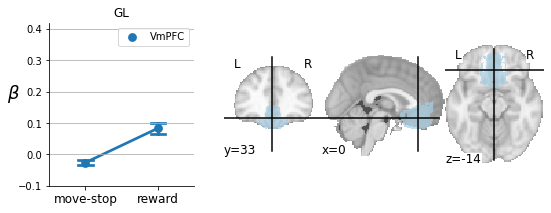

In [27]:
fig = plt.figure(figsize=(12, 3), constrained_layout=False)
gs = fig.add_gridspec(nrows=1, ncols=4)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1:3]))

ax = axs[0]
# ax = sns.violinplot(
#     data=dh, x='source', y='beta'
#     , hue='ROI'
#     , ci='sd', capsize=.3
#     , ax=ax
# )
order = ['move-stop', 'reward']
ax = sns.pointplot(
    data=dh, x='source', y='beta'
    , hue='ROI', order=order
    , capsize=0.2, ci=68
    , ax=ax
)

# ## t-test #1
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([-.2,-.2],[.8,.86], 'k-')
# ax.plot([.2,.2],[.62,.86], 'k-')
# ax.plot([-.2,.2],[.86,.86], 'k-')
# ax.text(-.04,.89, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='reward')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(-.33, .72, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='reward')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(.07, .54, convert_pvalue_to_asterisks(pval))

# ## t-test #3
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_ind(a,b)
# ax.plot([.8,.8],[.35,.38], 'k-')
# ax.plot([1.2,1.2],[.29,.38], 'k-')
# ax.plot([.8,1.2],[.38,.38], 'k-')
# ax.text(.95,.41, convert_pvalue_to_asterisks(pval))

# ## t-test #2
# a = df[(df.source=='move-stop')&(df.ROI=='putamen')].beta
# tval, pval = stats.ttest_1samp(a, popmean=0)
# ax.text(.72, .27, convert_pvalue_to_asterisks(pval))
# b = df[(df.source=='move-stop')&(df.ROI=='caudate')].beta
# tval, pval = stats.ttest_1samp(b, popmean=0)
# ax.text(1.12, .21, convert_pvalue_to_asterisks(pval))

ax.set(ylim=(-0.1, 0.42))
ax.grid(axis='y')
ax.legend(loc='best')
ax.set_ylabel(r'$\beta$', fontsize=18, rotation=0)
ax.set_xlabel('', fontsize=0)
ax.set_xticklabels(order, fontsize=12)
ax.set_title('GL')

sns.despine()

ax = axs[1]
nilearn.plotting.plot_roi(img_roi, cmap='Paired', axes=ax)

# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GL/GL.GLM.striatum.violinplot.png'
#     , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

In [17]:
stats.ttest_1samp(df[df.ROI=='NAc'].beta, popmean=0.)

Ttest_1sampResult(statistic=4.5403710165295195, pvalue=0.00014636502835794444)

In [18]:
a = df[df.ROI=='putamen'].beta
b = df[df.ROI=='NAc'].beta
stats.ttest_ind(a,b)

Ttest_indResult(statistic=2.7302172444482102, pvalue=0.008940778917302307)

---

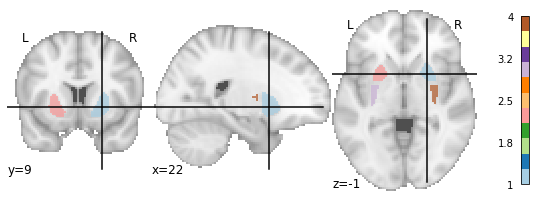

In [7]:
img_putamen = join(dir_mask, 'mask.putamen_4parts.nii')
nilearn.plotting.plot_roi(img_putamen, cmap='Paired', colorbar=True)

In [8]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_putamen, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['raPU', 'laPU', 'lpPU', 'rpPU']
)

In [21]:
df = pd.DataFrame(columns=['subj', 'condition', 'ROI', 'AP', 'LR', 'beta'])
df

,subj,condition,ROI,AP,LR,beta


In [22]:
for subj in tqdm(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_GLM_movement, '%s.Move-Stop_GLT#0_Coef.tlrc.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'a' in label else ('posterior' if 'p' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
df

100%|██████████| 24/24 [00:00<00:00, 30.49it/s]


,subj,condition,ROI,AP,LR,beta
0,GL03,reward,caudate,invalid,left,0.187557
1,GL03,reward,caudate,invalid,left,0.161062
2,GL03,reward,caudate,invalid,right,0.107102
3,GL03,reward,caudate,invalid,right,0.241338
4,GL03,move-stop,caudate,invalid,left,0.010681
...,...,...,...,...,...,...
187,GL29,reward,caudate,invalid,right,0.169852
188,GL29,move-stop,caudate,invalid,left,-0.024600
189,GL29,move-stop,caudate,invalid,left,-0.025971
190,GL29,move-stop,caudate,invalid,right,-0.016057


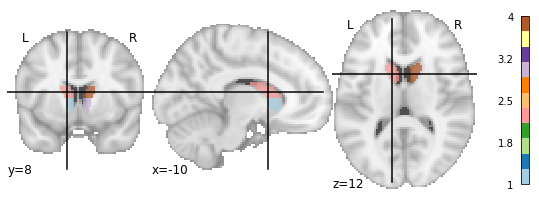

In [23]:
img_caudate = join(dir_mask, 'mask.caudate_4parts.nii')
nilearn.plotting.plot_roi(img_caudate, cmap='Paired', colorbar=True)

In [24]:
## `3dmaskave` 와 결과 일치하는 것 확인함.
masker = NiftiLabelsMasker(
    labels_img=img_caudate, memory='/home/sungbeenpark/trash/nilearn_cashe', verbose=0
    , labels=['lhCN', 'lbCN', 'rhCN', 'rbCN']
)

In [25]:
for subj in tqdm(list_subj):
    ## reward
    img_beta = join(dir_GLM_reward, '%s/%s.Rew#1_Coef.tlrc.nii'%(subj,subj))
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'reward', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
    ## move-stop
    img_beta = join(dir_GLM_movement, '%s.Move-Stop_GLT#0_Coef.tlrc.nii'%subj)
    betas = masker.fit_transform(img_beta)[0]
    for label, beta in zip(masker.labels, betas):
        ap = 'anterior' if 'h' in label else ('posterior' if 'b' in label else 'invalid')
        lr = 'left' if 'l' in label else ('right' if 'r' in label else 'invalid')
        roi = 'putamen' if 'PU' in label else ('caudate' if 'CN' in label else 'invalid')
        df = df.append(
            {'subj':subj, 'condition':'move-stop', 'ROI':roi, 'AP':ap, 'LR':lr, 'beta':beta}
            , ignore_index=True
        )
df

100%|██████████| 24/24 [00:00<00:00, 28.29it/s]


,subj,condition,ROI,AP,LR,beta
0,GL03,reward,caudate,invalid,left,0.187557
1,GL03,reward,caudate,invalid,left,0.161062
2,GL03,reward,caudate,invalid,right,0.107102
3,GL03,reward,caudate,invalid,right,0.241338
4,GL03,move-stop,caudate,invalid,left,0.010681
...,...,...,...,...,...,...
379,GL29,reward,caudate,posterior,right,0.169852
380,GL29,move-stop,caudate,anterior,left,-0.024600
381,GL29,move-stop,caudate,posterior,left,-0.025971
382,GL29,move-stop,caudate,anterior,right,-0.016057


In [15]:
img_striatum = nilearn.image.math_img(img1=img_caudate, formula='img1*0')
img_striatum = nilearn.image.math_img(
    img1=img_striatum, img2=img_caudate, img3=img_putamen
    , formula='img1 + img2 + (img3*10)'
)

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


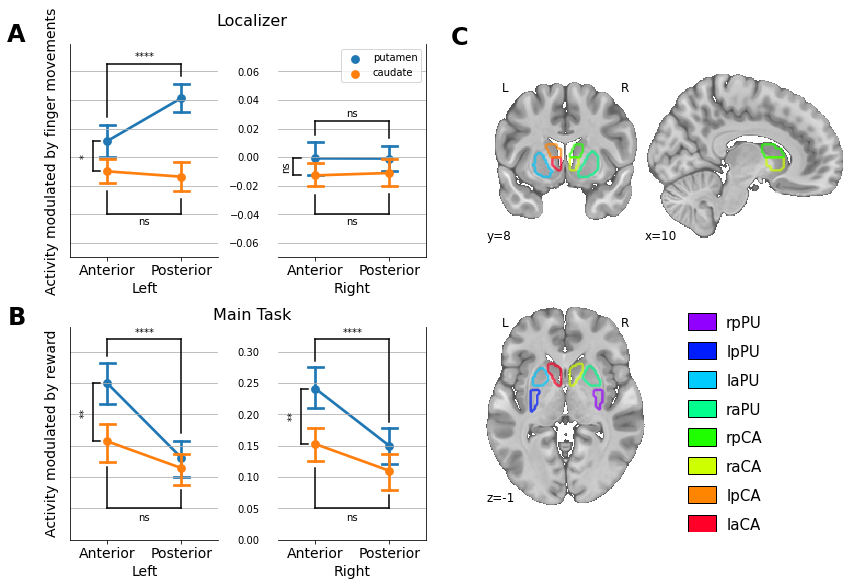

In [18]:
ncols, nrows = 4, 2

fig = plt.figure(figsize=(ncols*3, nrows*4), constrained_layout=False)
gs = fig.add_gridspec(nrows=nrows, ncols=ncols)

axs = []
axs.append(fig.add_subplot(gs[0,0]))
axs.append(fig.add_subplot(gs[0,1]))
axs.append(fig.add_subplot(gs[1,0]))
axs.append(fig.add_subplot(gs[1,1]))
axs.append(fig.add_subplot(gs[:,2:]))
                
############
## Reward ##
############
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [0., 0.34]
ylabel = 'Activity modulated by reward'
xApart, yApart = 0.1, 0.01

## Left
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[2]
)
ax.set_xlabel('Left', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(
    -0.3, 1.1, 'B'
    , transform=ax.transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.32
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.05
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='reward')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[3]
)
ax.set_xlabel('Right', fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_ylabel('')
ax.tick_params(axis='y', direction='out', width=0, pad=15)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.32
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='reward')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = 0.05
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart+0.005), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

###############
## Move-Stop ##
###############
xlim = [-0.5, 1.5]
xticks = ['Anterior','Posterior']
ylim = [-0.07, 0.079]
ylabel = 'Activity modulated by finger movements'
xApart, yApart = 0.1, 0.005

## Left
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='left')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[0]
)
ax.set_xlabel('Left', fontsize=14)
ax.set_ylabel(ylabel, fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_yticklabels('')
ax.tick_params(axis='y', direction='out', width=0)
ax.get_legend().remove()
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(
    -0.3, 1.1, 'A'
    , transform=ax.transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.2
ax.plot([x - xApart, xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - xApart, xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.065
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='left')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.04
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xL], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

## Right
ax = sns.pointplot(
    data=df[(df.condition=='move-stop')&(df.LR=='right')], x='AP', y='beta', hue='ROI'
    , capsize=0.2, ci=68
    , ax=axs[1]
)
ax.set_xlabel('Right', fontsize=14)
ax.set_xticklabels(xticks, fontsize=14)
ax.set_ylabel('')
ax.tick_params(axis='y', direction='out', width=0, pad=15)
ax.grid(axis='y')
ax.set(xlim=xlim, ylim=ylim)
ax.legend(loc='upper right')
# ax.legend(bbox_to_anchor=[1.7, .6])
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

### paired t-test
a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
x = 0
xLEdge = x - 0.3
ax.plot([x - (xApart+0.1), xLEdge], [a.mean(), a.mean()], 'k-')
ax.plot([x - (xApart+0.1), xLEdge], [b.mean(), b.mean()], 'k-')
ax.plot([xLEdge, xLEdge], [a.mean(), b.mean()], 'k-')
ax.text(
    xLEdge-(xApart), 0.5*(a.mean()+b.mean()), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=90, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='putamen')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='putamen')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yUEdge = 0.025
ax.plot([xL, xL], [a.mean()+a.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xR], [b.mean()+b.sem()+yApart, yUEdge], 'k-')
ax.plot([xR, xL], [yUEdge, yUEdge], 'k-')
ax.text(
    0.5*(xR+xL), yUEdge+yApart, convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

a = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='anterior')&(df.ROI=='caudate')].beta
b = df[(df.condition=='move-stop')&(df.LR=='right')&(df.AP=='posterior')&(df.ROI=='caudate')].beta
tval, pval = stats.ttest_rel(a,b)
xL, xR = 0, 1
yDEdge = -0.04
ax.plot([xL, xL], [a.mean()-(a.sem()+yApart), yDEdge], 'k-')
ax.plot([xR, xR], [b.mean()-(b.sem()+yApart), yDEdge], 'k-')
ax.plot([xL, xR], [yDEdge, yDEdge], 'k-')
ax.text(
    0.5*(xR+xL), yDEdge-(yApart), convert_pvalue_to_asterisks(pval)
    , ha='center', va='center', rotation=0, size=10
)

fig.tight_layout()

## Plotting Nilearn ROIs
display = nilearn.plotting.plot_roi(
    img_striatum, black_bg=False
    , bg_img=bg_img
    , display_mode='tiled', cut_coords=(10,8,-1), draw_cross=False
    , view_type='contours', linewidths=2.5
    , cmap='gist_rainbow'
    , axes=axs[4]
)
plt.text(
    -0.05, 1.038, 'C'
    , transform=axs[4].transAxes
    , fontsize=24, fontweight='bold', va='top', ha='right'
)
# display.add_contours(img_striatum, filled=False, cmap='gist_rainbow')

### legend
rois = ['laCA', 'lpCA', 'raCA', 'rpCA', 'raPU', 'laPU', 'lpPU', 'rpPU']
nax = fig.add_axes([0.8, 0.1, .16, .4])

cmap = get_cmap('gist_rainbow')
colors = np.round(np.linspace(0, cmap.N-1, len(rois)+1)).astype(int)

for ii, roi in enumerate(rois):
    rgb = cmap(colors[ii])
    x, y = 0, 0 + 0.125*ii
    w, h = 0.2, 0.075 
    nax.add_patch(Rectangle((x,y),w , h, facecolor=rgb, edgecolor='k'))
    nax.text(x+.4, y+0.03, roi, fontsize=15, horizontalalignment='center', verticalalignment='center')        
    
nax.axis('off')

## Titles
axs[2].text(
    1.95, 0.37, 'Main Task'
    , fontsize=16, va='top', ha='center'
)
axs[0].text(
    1.95, 0.1, 'Localizer'
    , fontsize=16, va='top', ha='center'
)

######################################
fig.savefig(
    '/home/sungbeenpark/Github/labs/GL/results/GL.GLM.pointplot_with_ROIs.png'
    , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

In [17]:
pg.rm_anova(
    data=df[(df.condition=='move-stop')&(df.LR=='left')]
    , dv= 'beta'
    , subject='subj'
    , within=['AP','ROI']
    , effsize='np2'
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,AP,0.004165,1,23,0.004165,10.925740,0.003090,0.003090,0.322049,1.0
1,ROI,0.034847,1,23,0.034847,30.470025,0.000013,0.000013,0.569852,1.0
2,AP * ROI,0.006847,1,23,0.006847,20.361053,0.000157,0.000157,0.469570,1.0


In [18]:
anova = AnovaRM(
    data=df
    , depvar='beta'
    , subject='subj'
    , within=['condition', 'ROI', 'AP', 'LR']
)
print(anova.fit())

                      Anova
                    F Value Num DF  Den DF Pr > F
-------------------------------------------------
condition           42.3476 1.0000 23.0000 0.0000
ROI                 10.2324 1.0000 23.0000 0.0040
AP                  14.7867 1.0000 23.0000 0.0008
LR                   1.7078 1.0000 23.0000 0.2042
condition:ROI        0.4812 1.0000 23.0000 0.4948
condition:AP        22.1627 1.0000 23.0000 0.0001
ROI:AP               3.3640 1.0000 23.0000 0.0796
condition:LR         5.8305 1.0000 23.0000 0.0241
ROI:LR               3.4990 1.0000 23.0000 0.0742
AP:LR                0.0003 1.0000 23.0000 0.9853
condition:ROI:AP     9.5603 1.0000 23.0000 0.0051
condition:ROI:LR     0.7955 1.0000 23.0000 0.3817
condition:AP:LR      8.1021 1.0000 23.0000 0.0091
ROI:AP:LR            0.0497 1.0000 23.0000 0.8255
condition:ROI:AP:LR  4.9289 1.0000 23.0000 0.0365



---

---

In [7]:
threshold = 3.291 # This is a z-score for p=0.001

In [8]:
zscore_reward = join('/mnt/ext6/GL/fmri_data/stats/GLM.reward/GL.reward.group.Zscore.n24.nii')
zscore_motor = join('/mnt/ext6/GL/fmri_data/stats/GLM.Move_Stop/GL.move-stop.group.Zscore.n24.nii')

/tmp/ipykernel_1303527/983301442.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


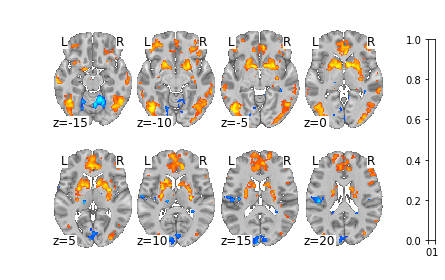

In [53]:
fig, axs = plt.subplots(nrows=2)

cut_coords = range(-15,21,5)
axis = 'z'
cmap=nilearn_cmaps['cold_hot']

display = nilearn.plotting.plot_stat_map(
    stat_map_img=zscore_reward, bg_img=bg_img
    , black_bg=False
    , threshold=threshold
    , symmetric_cbar=True
    , display_mode=axis
#     , display_mode='mosaic'
    , cmap=cmap, colorbar=False
    , cut_coords=cut_coords[:4]
#     , cut_coords=4
    , axes=axs[0]
)

display = nilearn.plotting.plot_stat_map(
    stat_map_img=zscore_reward, bg_img=bg_img
    , black_bg=False
    , threshold=threshold
    , symmetric_cbar=True
    , display_mode=axis
#     , display_mode='mosaic'
    , cmap=cmap, colorbar=False
    , cut_coords=cut_coords[4:]
#     , cut_coords=4
    , axes=axs[1]
)

cax = fig.add_axes([1, .15, .015, .7])
# cbar = fig.colorbar(axs[1], cax=cax)
# cbar.ax.tick_params(labelsize=25)

fig.tight_layout()

---

In [14]:
tmp = nilearn.image.math_img(
    img1=zscore_reward, img2=zscore_motor
    , formula='img1*(img1>%f) - img2*(img2>%f)'%(threshold, threshold)
)


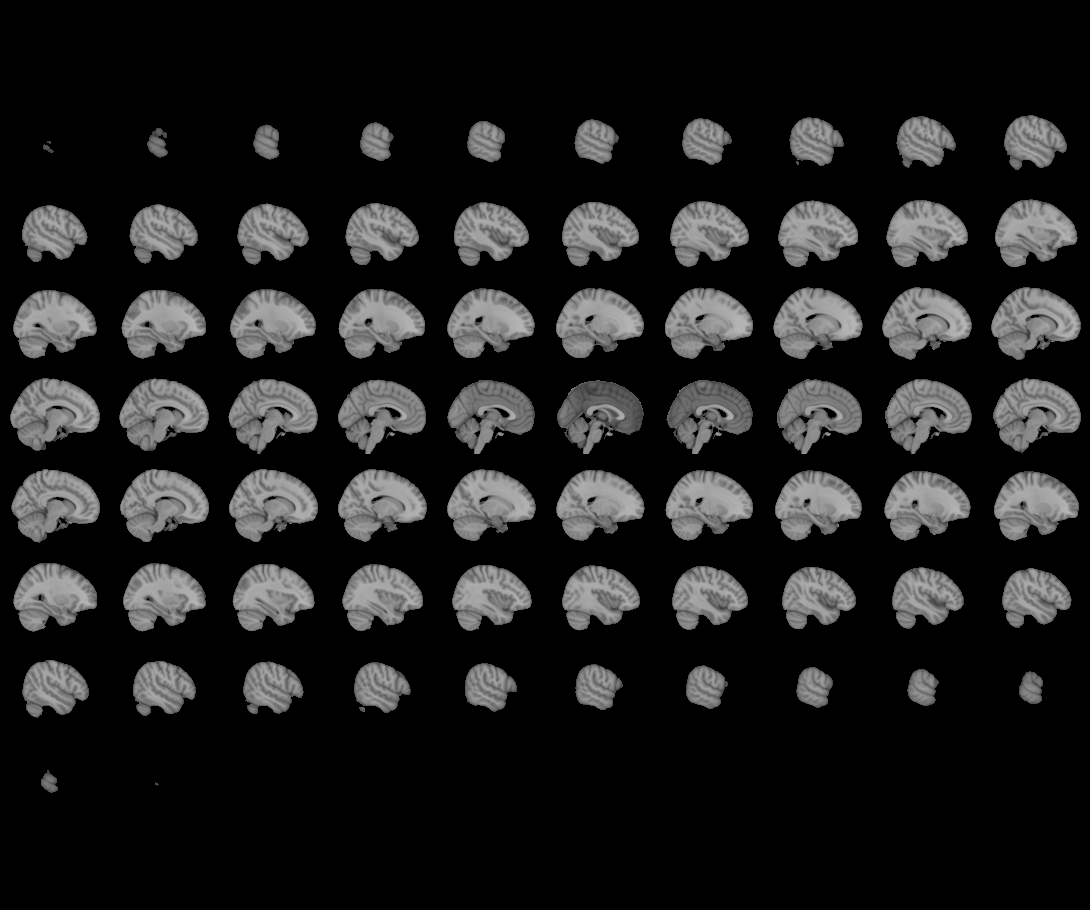
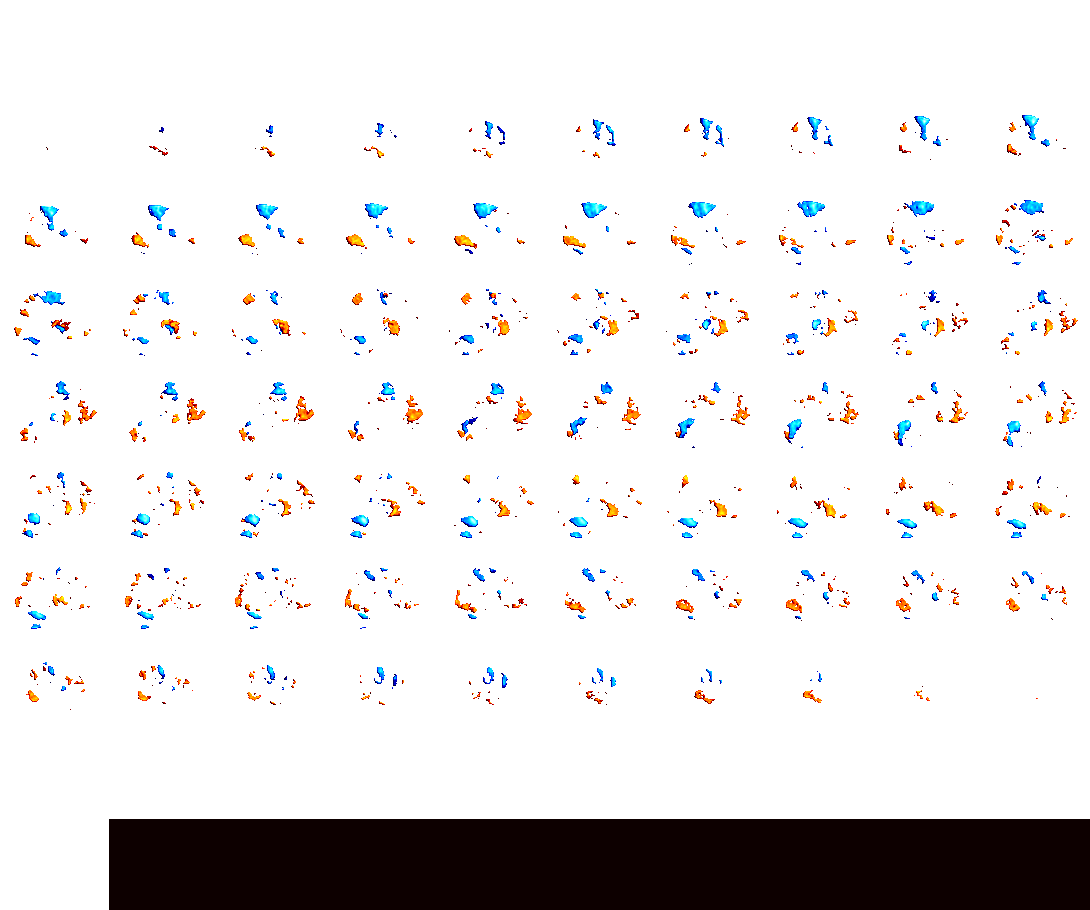

In [16]:
nilearn.plotting.view_img(tmp)

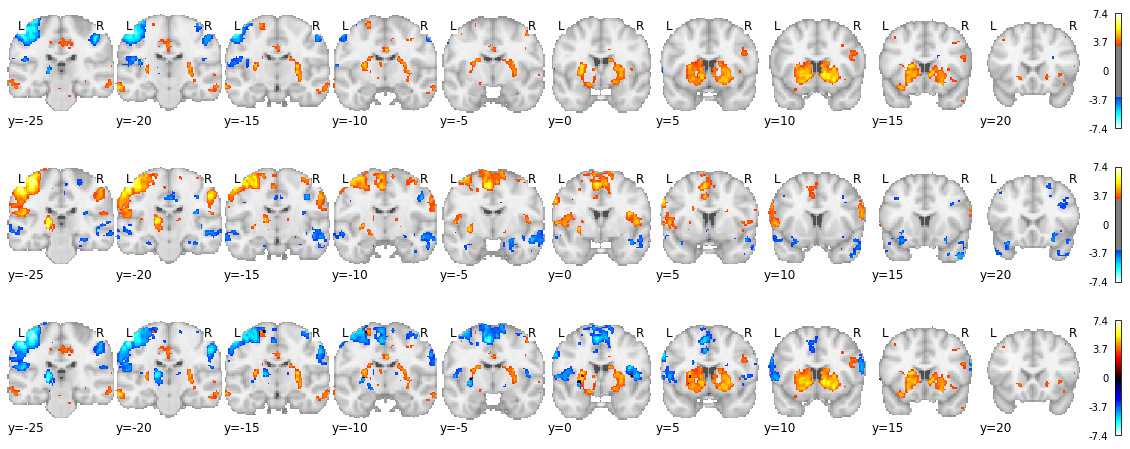

In [19]:
fig, axs = plt.subplots(nrows=3, figsize=(20, 8))

cut_coords = range(-25,21,5)
vmax = 7.4
axis = 'y'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    zscore_reward
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[0]
)

nilearn.plotting.plot_stat_map(
    zscore_motor
    , threshold=threshold
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[1]
)

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=axs[2]
)

# fig.tight_layout()

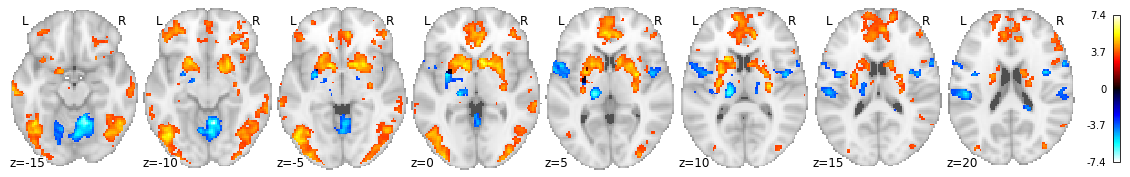

In [17]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-15,21,5)
vmax = 7.4
axis = 'z'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()

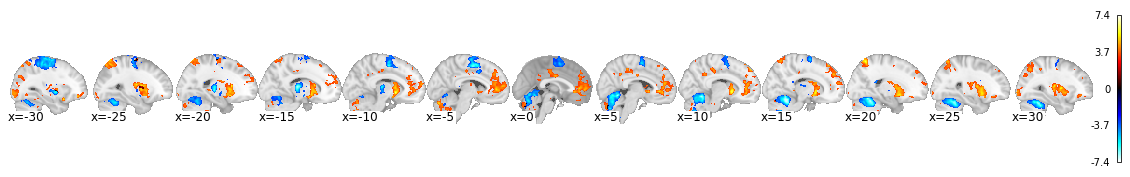

In [18]:
fig, ax = plt.subplots(figsize=(20, 3))

cut_coords = range(-30,31,5)
vmax = 7.4
axis = 'x'
cmap=nilearn_cmaps['cold_hot']

nilearn.plotting.plot_stat_map(
    tmp
    , symmetric_cbar=True, vmax=vmax
    , display_mode=axis
    , cmap=cmap
    , cut_coords=cut_coords
    , axes=ax
)

# fig.tight_layout()